<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Tools</h1>

<h1 style="color:#FF5733 ; font-size:15px"> CommPy</h1> is an open source toolkit implementing digital communications algorithms in Python using NumPy and SciPy.

In [1]:
pip install scikit-commpy

Note: you may need to restart the kernel to use updated packages.


<h1 style="color:#006400">Libraries</h1>

In [2]:
from statistics import mean
import numpy as np
from numpy.random import *
from numpy import *
from numpy.linalg import inv
from commpy.utilities import *
from commpy.modulation import QAMModem
from commpy.channels import *
from commpy.links import *
from math import *
import matplotlib.pyplot as plt
import time 

<h1 style="color:#006400">Functions</h1>

### 1. High Power Amplifier Output  

In [3]:
def hpa_sspa_modif_rapp(vin,Vsat,p,q,G,A,B):
    A=-345
    a0=abs(vin)
    theta=np.angle(vin)
    Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
    Bm=(A*(a0**q))/((1+(a0/B)**(q)))
    vout=Am*np.exp(1j*(theta+Bm))
    return(vout)
    

### 2. Non Linear Distortion Parameters  

In [4]:
def find_K0_sigma2_d(vin,vout):
    K0 = np.mean(vout*np.conj(vin))/np.mean(np.absolute(vin)**2)
    sigma2_d = np.var(vout - K0*vin)
    return(K0,sigma2_d)

<h1 style="color:#006400">Basic PA Non linear Distortion Model </h1>

In [5]:
IBO=1
p=1.1
q=4
Vsat=1.9
G=16
A=-345
B=0.17
val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt(10**(-IBO/10))
s=np.random.randn(1,1000000)
vin1 = np.sqrt(1/2)*(s+1j*s)
vin01 = coeff_IBO_m1dB*vin1
a0=np.absolute(vin01)
a02=a0**2  
theta=np.angle(vin01)
Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
Bm=(A*(a0**q))/((1+(a0/B)**(q)))
Sm=Am*np.exp(1j*(Bm))
vout1=Am*np.exp(1j*(theta+Bm))
K0 = np.mean(vout1*np.conj(vin01))/np.mean(np.absolute(vin01)**2)
sigma2_d = np.var(vout1 - K0*vin01) 
print(K0)
print(sigma2_d)

(12.804034357960463-0.44343761084051253j)
0.013572902343040375


<h1 style="color:#006400">Training Dataset </h1>

Generate 1000 H; 
For each H, we have 5000 S (input of NN1) and 5000 X_gd (output of NN1)

In [6]:
Mr=10
Mt=100
M=16
SNRdb=600
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
GD_Execution_time=0
HH=np.zeros((1,2000))
S=np.zeros((400000,20))
ZZ=np.zeros((400000,10),dtype=complex)
Niter=50
mu1=0.0022
lamda=0.00071
mu2=1
eps=1e-2
x_gd=np.zeros([Mt,1])
X_gd=np.zeros((400000,100))
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])
X=np.zeros((400000,200))
H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt))
HR=H.flatten()
realh=np.real(HR)
imagh=np.imag(HR)
Hr=np.concatenate((realh,imagh),axis=0).reshape(-1,1)
Hr=np.reshape(Hr, (2000, 1)).T
HH=Hr
for j in range(400000):
    bits = np.random.randint(2, size=int(N_bits))
    QAM16 = QAMModem(16)
    z=QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j]=Z.T
    reals=np.real(Z.T)
    imags=np.imag(Z.T)
    s=np.concatenate((reals,imags),axis=1)
    S[j]=s
    ## CDm algo
    for i in range(Niter):
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z)
        x_gd=x_gd-mu1*gdx1
        realx=np.real( x_gd)
        imagx=np.imag( x_gd)
        x_z=np.concatenate((realx,imagx),axis=0).T
        X[j]=x_z
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*x_gd
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d=vout2-K0*vin2
        y_gd =np.array(vout2/coeff_IBO_m1dB)
       

<h1 style="color:#006400"> Data Normalization </h1>

In [7]:
X_train=S[:350000,:]
y_train=X[:350000,:]

X_test=S[350000:,:]
y_test=X[350000:,:] 


<h1 style="color:#006400"> Artifical Neural Network</h1>

In [9]:
def NNMSE(y_true,y_pred_test):
    NMSE=np.zeros([1000,1])
    recievehh=np.zeros([1000,10],dtype=complex)
    Y_gdr=y_pred_test[:,:100]
    Y_gdi=y_pred_test[:,100:]
    Y_gd=Y_gdr+1j*Y_gdi
    Shr=X_test[:,:10]
    Shi=X_test[:,10:20]
    SSh=Shr+1j*Shi
    for i in range(1000):
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*Y_gd[i]
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        Y_gd_amp = vout2/coeff_IBO_m1dB
        recieveh=(H.dot(Y_gd_amp)).reshape((10))
        recievehh[i]=recieveh
        NMSE[i]=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
        NMSEdb=10*np.log10(np.mean(NMSE))
    #recievehhh=recievehh.flatten()
    #realr=np.real(recievehhh)
    #imagr=np.imag(recievehhh)
    #plt.scatter(realr,imagr) 
    return NMSEdb

In [10]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [11]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [47]:
import tensorflow as tf
import keras.backend as K
def Mean(lst): 
    return sum(lst) / len(lst) 
def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator
def NMSE(y_true, y_pred):
    NMS=K.zeros(shape=(1000))
    NMSEdb=K.zeros(shape=(1000))
    #recieveh=K.zeros([1000,10])
    y_predt=tf.convert_to_tensor(y_pred,dtype=tf.float32)
    Y_gdr=y_predt[:1000,:100]
    Y_gdi=y_predt[:1000,100:]
    Y_gd=tf.complex(Y_gdr,Y_gdi)
    X_testt=tf.convert_to_tensor(X_train,dtype=tf.float32)
    Shr=X_testt[:1000,:10]
    Shi=X_testt[:1000,10:20]
    SSh=tf.complex(Shr,Shi)
    NMSE=[]
    for i in range(1000):
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*tf.math.sqrt((1/K.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*Y_gd[i]
        A=-345
        a0=K.abs(vin2)
        theta=tf.math.angle(vin2)
        Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
        Bm=(A*(a0**q))/((1+(a0/B)**(q)))
        vout2=tf.complex(Am,0.0)*tf.math.exp(tf.complex(0.0,theta+Bm))
        Y_gd_amp = vout2/coeff_IBO_m1dB
        Y_gd_amp0=K.reshape(Y_gd_amp,(100,1))
        HH=K.constant(H,dtype=complex64)
        recieveh=K.dot(HH,(Y_gd_amp0))
        recievehh=K.reshape(recieveh,(1,10))
        NMS=K.mean(K.abs(tf.math.subtract(recievehh,SSh[i])**2))/K.mean(K.abs(SSh[i])**2)
        #NMSE.append(NMS)
        #NMSEdb=10*log10(Mean(NMSE))
        NMSEdb=10*log10(K.mean(NMS))
    return NMSEdb
        

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
model = Sequential()
#keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.1, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'relu', input_dim =20))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'selu'))
model.compile(optimizer = 'Adamax', loss = root_mean_squared_error, metrics = ['mae',NMSE])
history =model.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=10000, epochs=4000, shuffle=True)
y_pred= model.predict(X_train)

Train on 350000 samples, validate on 50000 samples
Epoch 1/4000
350000/350000 [==============================] - 8s 24us/step - loss: 0.0435 - mae: 0.0344 - NMSE: 2.4753 - val_loss: 0.0211 - val_mae: 0.0168 - val_NMSE: 3.4546
Epoch 2/4000
350000/350000 [==============================] - 3s 10us/step - loss: 0.0167 - mae: 0.0132 - NMSE: 2.8229 - val_loss: 0.0132 - val_mae: 0.0105 - val_NMSE: 3.8862
Epoch 3/4000
350000/350000 [==============================] - 3s 10us/step - loss: 0.0114 - mae: 0.0090 - NMSE: 3.0957 - val_loss: 0.0100 - val_mae: 0.0079 - val_NMSE: 4.0421
Epoch 4/4000
350000/350000 [==============================] - 3s 9us/step - loss: 0.0093 - mae: 0.0074 - NMSE: 3.0232 - val_loss: 0.0087 - val_mae: 0.0069 - val_NMSE: 4.0658
Epoch 5/4000
350000/350000 [==============================] - 3s 10us/step - loss: 0.0084 - mae: 0.0067 - NMSE: 3.6352 - val_loss: 0.0081 - val_mae: 0.0064 - val_NMSE: 4.0938
Epoch 6/4000
350000/350000 [==============================] - 3s 10us/step 


# <h1 style="color:#006400"> Weights Vector of NN1</h1>

In [11]:
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0)
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0)
weights=np.concatenate((first_layer,second_layer),axis=0)
print (len(weights))

88600


<h1 style="color:#006400"> Make Predictions</h1>

In [30]:

y_pred= model.predict(X_train)
#y_pred_test = model.predict(X_test)

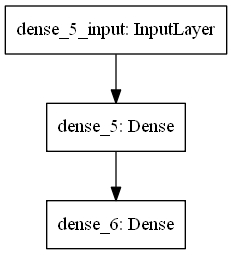

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

<h1 style="color:#006400"> Accuracy Representation </h1>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Loss Representation</h1>

In [27]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<h1 style="color:#006400"> Mean-Squared-Error</h1>

# Test Set 

In [31]:
NMSE=np.zeros([1000,1])
recievehh=np.zeros([1000,10],dtype=complex)
Y_gdr=y_pred_test[:,:100]
Y_gdi=1j*y_pred_test[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_test[:,:10]
Shi=1j*X_test[:,10:20]
SSh=Shr+Shi
for i in range(1000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE))
#recievehhh=recievehh.flatten()
#realr=np.real(recievehhh)
#imagr=np.imag(recievehhh)
#plt.scatter(realr,imagr) 
print('Mean Squred Error:', NMSEdb)


Mean Squred Error: -28.941871041108605


In [33]:
print(NMSE(y_train,y_pred))

TypeError: 'numpy.ndarray' object is not callable

In [32]:
print(NMSE(X_test,y_test))

TypeError: 'numpy.ndarray' object is not callable